In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Downloading Data

Downloading Data

In [ ]:
!wget "https://data.mendeley.com/public-files/datasets/rp73yg93n8/files/56487963-3773-495e-a4fc-c1862b6daf91/file_downloaded" -P "/content/drive/My Drive/MLSec/hw2"

In [ ]:
!unzip "/content/drive/My Drive/MLSec/hw2/file_downloaded.2" -d "/content/drive/My Drive/MLSec/hw2"

###Data Preparation

device: cpu
images-size: torch.Size([128, 3, 100, 100])
out-size: torch.Size([3, 1634, 818])


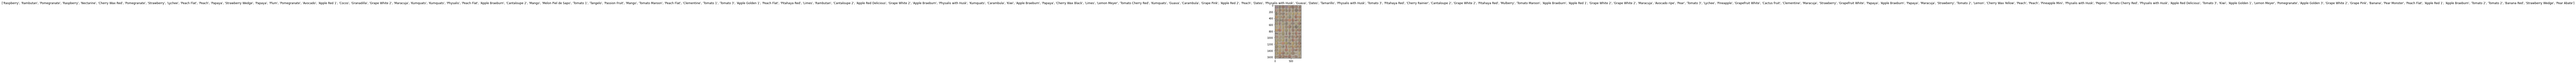

In [ ]:
batch_size = 128
learning_rate = 1e-3
trnsform = transforms.Compose(
[
    transforms.ToTensor()
])

#loading data
train_dataset = datasets.ImageFolder(root='/content/drive/My Drive/MLSec/hw2/fruits-360/Training', transform=trnsform)
test_dataset = datasets.ImageFolder(root='/content/drive/My Drive/MLSec/hw2/fruits-360/Test', transform=trnsform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

def imageshow(input, title=None):
    
    input = input.cpu() if device else input
    input = input.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imageshow(out, title=[train_dataset.classes[x] for x in labels])

### Loading Resnet

In [ ]:
Resnet = models.resnet18(pretrained=True)
net = Resnet.cuda() if device=='cuda' else Resnet
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Adding a fully connected layer

In [ ]:
num_ftrs = net.fc.in_features
print('num_ftrs',num_ftrs) # 512
num_classes=81 # the fruit-360 dataset I have downloaded using the given link has 81 classes
net.fc = nn.Linear(num_ftrs, num_classes)
net.fc = net.fc.cuda() if device=='cuda' else net.fc

num_ftrs 512


### Training (to retrain weights for the new dataset)

In [ ]:
loss_funct = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

def correct_labels(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [ ]:
n_epochs = 4
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_steps = len(train_dataloader)
print('total_steps:', total_steps)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        #computing loss
        loss = loss_funct(outputs, target_)
        running_loss += loss.item()
        #backpropagation
        loss.backward()
        optimizer.step()

        correct += correct_labels(outputs, target_)
        total += target_.size(0)
        acc=correct_labels(outputs, target_) / target_.size(0)

        #printing loss
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, accuracy:{}' 
                   .format(epoch, n_epochs, batch_idx, total_steps, loss.item(),acc))

    accuracy=(correct / total)*100     
    train_acc.append(accuracy)
    train_loss.append(running_loss/total_steps)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {accuracy:.4f}')

    # evaluating on Test data
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)

            loss_t = loss_funct(outputs_t, target_t)
            batch_loss += loss_t.item()
            correct_t += correct_labels(outputs_t, target_t)

            total_t += target_t.size(0)
        
        v_acc=(correct_t/total_t)*100
        val_acc.append(v_acc)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {v_acc:.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

In [ ]:
import pickle

with open('./train_loss', 'wb') as pkl:
    pickle.dump(train_loss, pkl,protocol=pickle.HIGHEST_PROTOCOL)

with open('./train_acc', 'wb') as pkl:
    pickle.dump(train_acc, pkl,protocol=pickle.HIGHEST_PROTOCOL)

with open('./val_loss', 'wb') as pkl:
    pickle.dump(val_loss, pkl,protocol=pickle.HIGHEST_PROTOCOL)

with open('./val_acc', 'wb') as pkl:
    pickle.dump(val_acc, pkl,protocol=pickle.HIGHEST_PROTOCOL)

Plotting losses and accuracies

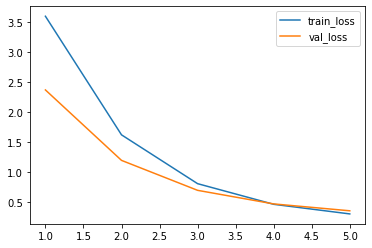

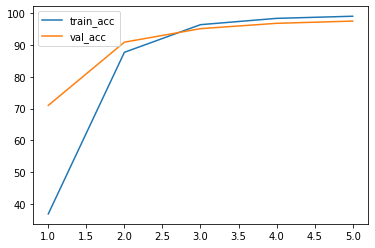

In [ ]:
plt.plot(np.arange(5)+1, train_loss, label='train_loss')
plt.plot(np.arange(5)+1, val_loss, label='val_loss')
plt.xlabel='epochs'
plt.ylabel='loss'
plt.legend()
plt.show()

plt.plot(np.arange(5)+1, train_acc, label='train_acc')
plt.plot(np.arange(5)+1, val_acc, label='val_acc')
plt.xlabel='epochs'
plt.ylabel='accuracy'
plt.legend()
plt.show()


We got accuracy=99% on train data and accuracy=97.5% on test data only after 5 epochs which shows the power of transfer learning. We started training by using the pretrained Resnet so we did not need to train weights from scratch. Since usually the first layes of CNNs recognize some simple patterns in data (such as horizontal and vertical lines) and first layers of resnet have been adjusted in a way to recognize these patterns, these weights do not need major changes for the new dataset, and only last layers need to be fine-tuned. Therefore, the training process would be much faster as it can be seen from the results. 